In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import starry
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet
import theano.tensor as tt
import arviz as az


plt.rcParams['font.family'] = 'Serif'

starry.config.quiet = True
starry.config.lazy = True

print("Import good.")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Import good.


In [17]:
time = []; flux = []; ferr = []
with open("timedata.txt", 'r') as timedata:
    for t in timedata:
        time.append(float(t))
with open("fluxdata.txt", 'r') as fluxdata:
    for f in fluxdata:
        flux.append(float(f))
with open("ferrdata.txt", 'r') as ferrdata:
    for err in ferrdata:
        ferr.append(float(err))

time = np.array(time); flux = np.array(flux); ferr = np.array(ferr)

print("Data read good.")

Data read good.


In [3]:
#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.4
A_r_e = 0.3

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.3

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 88.90036698
orb_inc_e = 1.0
orb_period = 10.54980498
orb_ecc = 0.50002396
long_periastron = 327.28588277
long_ascend = 90 #106


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

In [4]:
map_soln = {'A_M_lowerbound__': np.array(1.62944291),
 'A_R_lowerbound__': np.array(0.98037289),
 'A inc_periodic__': np.array([ 2.64709232, -3.60451579]),
 'A_prot_lowerbound__': np.array(0.07237746),
 'u1_lowerbound__': np.array(-2.24535639),
 'u2_lowerbound__': np.array(-1.84569244),
 'B_R_lowerbound__': np.array(0.90174968),
 'period_lowerbound__': np.array(2.35610737),
 'inc orb_interval__': np.array(-7.80442223),
 'ecc_interval__': np.array(-6.03156992),
 'long periastron_interval__': np.array(0.70180696),
 't0_interval__': np.array(0.10218496),
 'A_M': np.array(5.10103218),
 'A_R': np.array(2.66544997),
 'A inc': np.array(1.41243868),
 'A inc deg': np.array(80.92677536),
 'A_prot': np.array(1.07506106),
 'u1': np.array(0.1058898),
 'u2': np.array(0.15791594),
 'B_R': np.array(2.4639104),
 'period': np.array(10.54980498),
 'inc orb': np.array(88.90036698),
 'ecc': np.array(0.50002396),
 'long periastron': np.array(327.28588277),
 't0': np.array(2018.67830961)}

In [45]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    BoundedNormal = pm.Bound(pm.Normal, lower=0)
    
    # fix these 
    # A_m = map_soln["A_M"] #
    A_m = BoundedNormal("A_M", mu=A_m_m, sd=A_m_e, testval=A_m_m) # fix to MAP
    # A_r = map_soln["A_R"] #
    A_r = BoundedNormal("A_R", mu=A_r_m, sd=A_r_e, testval=A_r_m) # fix to MAP
    A_inc_rad = pmx.Periodic("A inc", lower=0, upper=np.pi/2) # fix to paper val
    A_inc = pm.Deterministic("A inc deg", A_inc_rad*180/np.pi) 
#     A_inc = 89.02 # from Liang et al
#     A_inc_rad = A_inc * np.pi / 180
#     A_prot = map_soln["A_prot"]
    A_prot = BoundedNormal("A_prot",mu=1.07,sd=0.1,testval=1.07)
    
    pm.Potential("isotropy", tt.log(tt.sin(A_inc_rad)))
    
    u1 = map_soln["u1"]
    u2 = map_soln["u2"]
    
    
    pri_map = starry.Map(udeg=2,ydeg=4) #ydeg = 2*order_approx udeg=2
    pri_map[1] = u1
    pri_map[2] = u2
    pri_map.inc= A_inc
    
    primary = starry.Primary(pri_map, m=A_m, r=A_r,prot=A_prot)

 
    B_r = map_soln["B_R"] #BoundedNormal("B_R",mu=B_r_m,sd=B_r_e,testval=B_r_m) # set to MAP value

    sec_map = starry.Map(udeg=2,ydeg=1)
    sec_map[1] = u1
    sec_map[2] = u2
    secondary = starry.kepler.Secondary(map=sec_map,
        m=4.4,  # mass in solar masses
        r=B_r,  # radius in solar radii
        porb = orb_period, # orbital period in days
        inc = orb_inc_m,
        Omega = long_ascend,  # longitude of ascending node in degrees
        ecc = orb_ecc,  # eccentricity
        # ecc = pm.Uniform("ecc", lower=0.50, upper=0.51, testval=0.505),
        w = long_periastron,  # longitude of pericenter in degrees
        # w = pm.Uniform("long periastron", lower=320.6, upper=330.6, testval=326.5),
        t0 = map_soln["t0"],  # set to MAP 
    )
    
    system = starry.System(primary, secondary)

print("Init model good.")

Init model good.


Reduction of approx.  100  times in data volume.
Reduced  16942  down to  1293  compared to the ideal  169


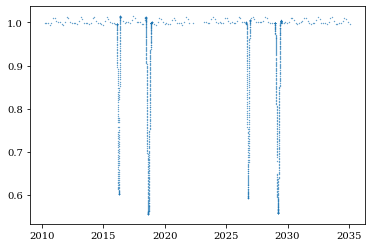

In [44]:
# now we need to reduce the number of points to work with in order to save on compute time
# first, find the indexes of points in each eclipse

MidPrimary1 = map_soln["t0"]; MidPrimary2 = map_soln["t0"] + orb_period
primary1index = [i for i, t in enumerate(time) if (MidPrimary1 - 0.25) <= t <= (MidPrimary1 + 0.25)]
primary2index = [i for i, t in enumerate(time) if (MidPrimary2 - 0.25) <= t <= (MidPrimary2 + 0.25)]

sec_t0 = 0; sec_t0Flux = 1
for i, t in enumerate(time):
    if 2015 <= t <= 2018:
        if flux[i] < sec_t0Flux:
            sec_t0Flux = flux[i]; sec_t0 = t
MidSecondary1 = sec_t0; MidSecondary2 = sec_t0 + orb_period
secondary1index = [i for i, t in enumerate(time) if (MidSecondary1 - 0.15) <= t <= (MidSecondary1 + 0.15)]
secondary2index = [i for i, t in enumerate(time) if (MidSecondary2 - 0.15) <= t <= (MidSecondary2 + 0.15)]

# now we create new arrays with reduced number of points
reduct = 100     # the number of times reduction in the number of data points
print("Reduction of approx. ", reduct, " times in data volume.")
running_ind = 0
running_time, running_flux, running_ferr = [], [], []
time_input, flux_input, ferr_input = [], [], []
for i, t in enumerate(time):
    if i not in primary1index + primary2index + secondary1index + secondary2index:  # if this point is NOT in an eclipse
        running_time.append(t) 
        running_flux.append(flux[i])
        running_ferr.append(ferr[i])
        if running_ind%reduct == 0:     # if we've reached the specified number of points to group together, take the mean and add them to the output list
            running_ind = 0
            time_input.append(np.mean(running_time))
            flux_input.append(np.mean(running_flux))
            ferr_input.append(np.mean(running_ferr))
            running_time, running_flux, running_ferr = [], [], []
        running_ind += 1
    else:   # if this point IS in an eclipse
        if running_ind != 0:    # check if we have a running total. If so, take the mean of that data and put it in the output list
            running_ind = 0
            time_input.append(np.mean(running_time))
            flux_input.append(np.mean(running_flux))
            ferr_input.append(np.mean(running_ferr))
            running_time, running_flux, running_ferr = [], [], []
        time_input.append(t)    # now append the eclipse data to the output list
        flux_input.append(flux[i])
        ferr_input.append(ferr[i])

time_input = np.array(time_input)   # make the lists into arrays
flux_input = np.array(flux_input)
ferr_input = np.array(ferr_input)

print("Reduced ", len(time), " down to ", len(time_input), " compared to the ideal ", int(len(time) / reduct))

plt.scatter(time_input, flux_input, s=0.1)

In [46]:
with model:
    system.set_data(flux_input, C=ferr_input**2)

    # Prior on primary
    pri_mu = np.zeros(primary.map.Ny)
    pri_mu[0] = 1
    pri_L = np.zeros(primary.map.Ny)
    pri_L[0] = 1e-2
    pri_L[1:] = 1e-2
    primary.map.set_prior(mu=pri_mu, L=pri_L)
    
    # Prior on secondary
    sec_mu = np.zeros(secondary.map.Ny)
    sec_mu[0] = 0.9
    sec_L = np.zeros(secondary.map.Ny)
    sec_L[0] = 1e-4
    sec_L[1:] = 1e-4
    secondary.map.set_prior(mu=sec_mu, L=sec_L)


    pm.Potential("marginal", system.lnlike(t=time_input))

print("Set data good.")

Set data good.


In [47]:
keys = ["A inc_periodic__", 
"A inc", 
"A inc deg", 
"A_prot_lowerbound__", 
"A_prot", 
'A_M_lowerbound__', 
'A_R_lowerbound__', 
'A_M',
'A_R']
# 'ecc_interval__', 
# 'long periastron_interval__', 
# 'ecc', 
# 'long periastron'
# ]

start_state = {}
for key in keys:
    start_state[key] = map_soln[key]

In [ ]:
print("Starting MCMC.")
with model:
    trace = pmx.sample(tune=50, draws=1000, start=start_state, chains=1, cores=1, 
                       target_accept=0.98)

print("MCMC Good.")

Starting MCMC.


C:\Users\ryanw\anaconda3\envs\StarryEnv\lib\site-packages\pymc3_ext\sampling\schedule.py:33: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x0000012A9CF4FAF0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x0000012A9CF4FAF0>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar

In [40]:
# trace.to_netcdf("DIHerMCMCFull.h5")
# to load from a .h5 file, use:
# samples = az.from_netcdf("DIHerMCMC.h5")
print("Saved file!")
display(pm.summary(trace))

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


Saved file!


C:\Users\ryanw\anaconda3\envs\StarryEnv\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A_M,2.336,0.029,2.284,2.388,0.001,0.001,1522.0,1264.0,1.00
A_R,2.099,0.007,2.087,2.111,0.000,0.000,1338.0,1286.0,1.00
A inc,1.425,0.029,1.372,1.480,0.003,0.002,73.0,137.0,1.03
A inc deg,81.652,1.642,78.609,84.773,0.192,0.137,73.0,137.0,1.03
A_prot,1.075,0.000,1.075,1.075,0.000,0.000,1712.0,1445.0,1.00


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ryanw\anaconda3\envs\StarryEnv\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


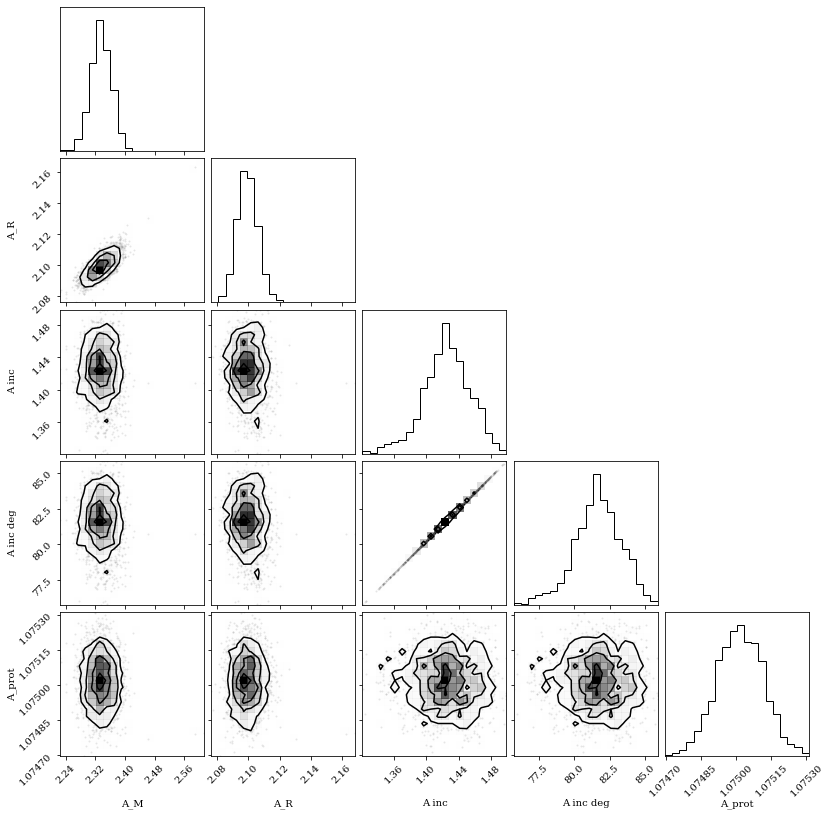

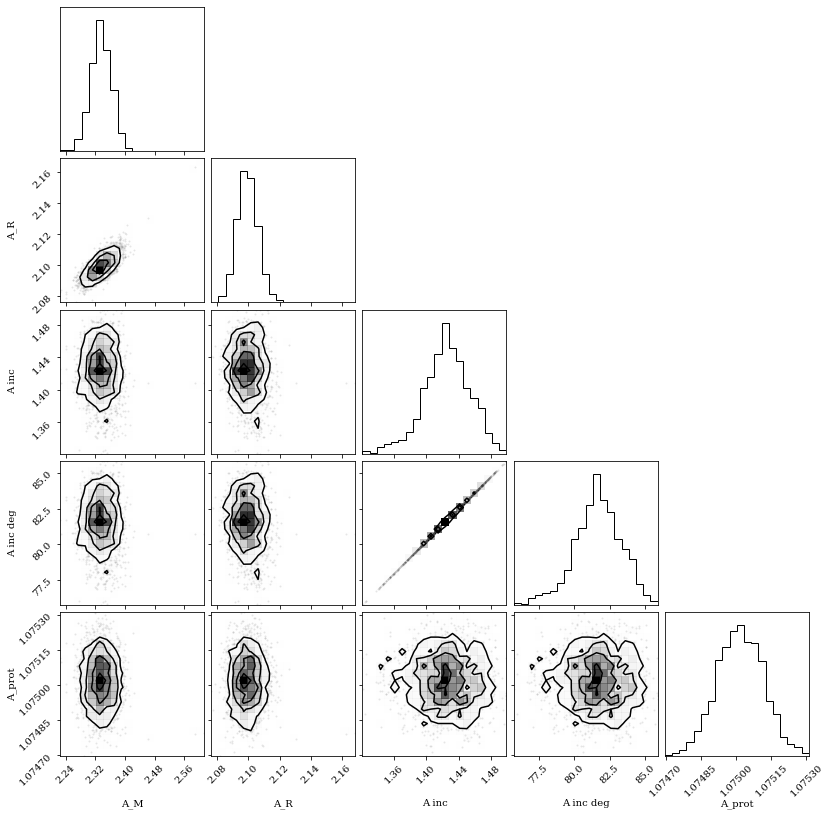

In [41]:
import corner as corner

corner.corner(trace)